# **Step 1: Loading and Viewing the Dataset**

In [28]:
!pip install -U fastai

     |████████████████████████████████| 194kB 15.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 12.8MB 245kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
# Imports for dataset manipulation
from google.colab import files
import io
import numpy as np
from itertools import zip_longest
import pandas as pd
import re
from numpy.random import RandomState

In [2]:
# Uploading the file for use in Google Colab (different than in Jupyter)
uploaded = files.upload()

Saving monojet_Zp2000.0_DM_50.0_chan3.csv to monojet_Zp2000.0_DM_50.0_chan3 (2).csv


Before we can read the dataset into a pandas dataframe, we must determine the maximum number of columns of any row in the dataset. To do this, we create a basic function called get_max_columns(file) to get the desired quantity. 



In [3]:
# Define a function to find maximum number of columns to in order to properly read file
def get_max_columns(url_to_file):
    f = open(url_to_file, "r")
    n = 0
    for line in f.readlines():
        items = len(re.split('[;,]', line))
        if items > n:
            n = items
    return n

# Create a list of numerical column labels using our get_max_columns function
cols = range(0, get_max_columns('monojet_Zp2000.0_DM_50.0_chan3.csv'))

We then read the dataset into a pandas dataframe to get a sense of what we're working with.

In [4]:
# If using Jupyter: 
# data_path = '/home/atlas/data/Desktop/GSoC2021_ATLAS_Evaluation-Exercise/monojet_Zp2000.0_DM_50.0_chan3.csv'
# orig_data = pd.read_csv(data_path, sep=",|;", names=cols, header=None)

# Read the dataset into a pandas dataframe
orig_data = pd.read_csv(io.BytesIO(uploaded['monojet_Zp2000.0_DM_50.0_chan3.csv']), sep=",|;", names=cols, header=None)

# Drop last column due to pandas reading an extra space
orig_data = orig_data.drop([65], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# **Step 2: Extracting the Jet Particles**

We only want the data for particles labeled 'j' in the original dataset, so we create a new dataframe consisting of only those particles. 

First, the orig_data is transformed into dataj, in which only the values of j are retained. The rest are NaNs.

Then, we create an array of the dataindices of the locations of all of the j values in dataj. 

Next, we clone each element of the array 4 times (E, pt, eta, phi) and concatenated the resulting array with one of the same length to add 1, 2, 3, and 4 respectively to each element, thus returning the coordinate locations of the data for each jet particle. We then convert this resulting array into a dataframe.

Next, we use the look_up function to add a column to this dataframe that contains the values in orig_data at each coordinate pair, thus extracting the data for each jet. These values are then grouped into 4s and converted into a final jets dataframe.


In [5]:
# Creating a dataframe that keeps only the 'j's
dataj = orig_data.where(orig_data == 'j')

# Determining the indices of all 'j's
dataindices = np.argwhere(np.array(dataj.notnull().values))
type(dataindices)

# Creating a dataframe, df, of all of the indices of the E, pt, eta, and phi values of 'j' particles
test = np.repeat(dataindices, 4, axis=0)
a = np.array([0, 0, 0, 0] * 22661)
b = np.array([1, 2, 3, 4] * 22661)
add = np.concatenate([a[:,None],b[:,None]], axis=1)
sum = np.add(test, add)
df = pd.DataFrame(sum, columns=['a','b'])

# Using lookup to add a column to df with the corresponding value from orig_data at that position
df['looked_up'] = orig_data.lookup(df.a, df.b)

# Define a grouper function to be used to group the 4 data points for each particle in df.looked_up
def grouper(iterable, n, fillvalue=None):
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

# Group df.looked_up and convert into jets dataframe
grouped = np.array(list(grouper(df.looked_up, 4)))
jets = pd.DataFrame(grouped, columns = ['E', 'pt', 'eta', 'phi'])

We define a custom normalization function for the data according to the custom unnormalization function given. 

In [6]:
# Define a custom normalization function
def custom_norm(df):
    df['E'] = np.log10(df['E'])
    df['pt'] = np.log10(df['pt'])
    df['eta'] = df['eta'] / 5
    df['phi'] = df['phi'] / 3    
    return df

# Normalize the jets dataframe
jets_norm = custom_norm(jets)

We then view our data and randomly split into training and validation sets (80/20).

In [7]:
# Check out jets dataframe
print('Jets:')
print(jets_norm.head())

print('\n')

print('The number of jets in dataset:', len(jets_norm))
print('\n')

# Randomly split the data into training and test (80/20)
rng = RandomState()
train = jets_norm.sample(frac=0.8, random_state=rng)
test = jets_norm.loc[~jets_norm.index.isin(train.index)]

# Check to verify
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Jets:
          E        pt       eta       phi
0  5.412833  5.386811  0.065792  0.750047
1  5.716080  5.035790 -0.449460 -0.618930
2  5.583226  4.946480  0.429032 -0.652117
3  4.596681  4.548575  0.094092 -0.388150
4  5.353012  4.429400 -0.563216 -0.753127


The number of jets in dataset: 22661


Training sample:
              E        pt       eta       phi
16878  5.632153  5.605191 -0.043774 -0.343757
6518   5.317206  4.629057 -0.452702 -0.522847
15301  5.613404  5.590645 -0.062191 -0.262348
8546   4.424584  4.403277 -0.063163 -0.187890
5012   5.649305  5.135924  0.369892  0.215650


Testing sample:
           E        pt       eta       phi
3   4.596681  4.548575  0.094092 -0.388150
11  4.450514  4.396663 -0.090853  0.172225
12  5.971604  5.789742  0.194677 -0.521973
15  5.522170  5.101307  0.323996 -0.618413
22  4.953363  4.598622 -0.289490 -0.426307


The number of entries in the training data: 18129
The number of entries in the validation data: 4532


Finally, we plot our training data to get a sense of the distributions for each component.

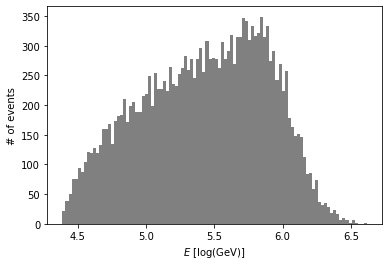

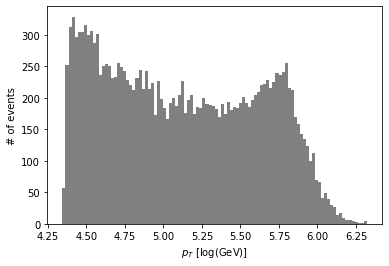

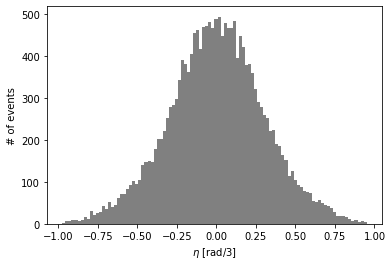

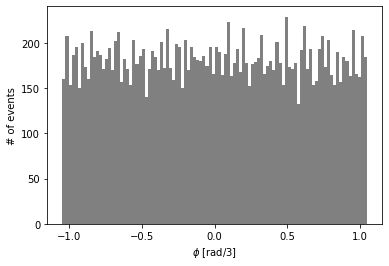

In [8]:
# Plot the data
%matplotlib inline
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E", "pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

# **Step 3: Setting Up the Network**

First, we import all necessary classes and packages. We also add the training and validation datasets as TensorDataset objects to Pytorch.

In [9]:
# Preparing the data
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import fastai

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We use the given batchsize and load the TensorDatasets into one DataLoaders object.

In [10]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

Next, we construct the framework of the network using the previously given conditions.

In [11]:
# Prepping the network
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We pick MSE as the loss function because it measures the desired (input-output)/input quantity we are looking to minimize when constructing an autoencoder.

In [12]:
# Loss
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#learn = basic_train.Learner(data=dls, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

We determine the optimal learning rate by plotting loss vs. learning rate for our model. I chose to use lr_steep, as both values were of similar orders of magnitude, and I have found this to be more accurate in previous models.

Learning rate with the minimum loss: 0.014454397559165954
Learning rate with the steepest gradient: 0.0020892962347716093


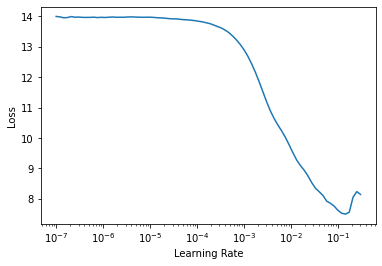

In [13]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

# **Step 4: Training the Network**

We now use fit_one_cycle to train the network. I kept n_epochs equal to 100 as the error seemed to relatively plateau around this point.

In [14]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 9.218608856201172, 6.0714826583862305, '00:00']
[0, 9.218608856201172, 6.0714826583862305, '00:00']
[1, 3.4096412658691406, 0.41241633892059326, '00:00']
[1, 3.4096412658691406, 0.41241633892059326, '00:00']
[2, 0.9693028926849365, 0.23116251826286316, '00:00']
[2, 0.9693028926849365, 0.23116251826286316, '00:00']
[3, 0.4027351140975952, 0.22599934041500092, '00:00']
[3, 0.4027351140975952, 0.22599934041500092, '00:00']
[4, 0.26908034086227417, 0.22574569284915924, '00:00']
[4, 0.26908034086227417, 0.22574569284915924, '00:00']
[5, 0.23719719052314758, 0.22563137114048004, '00:00']
[5, 0.23719719052314758, 0.22563137114048004, '00:00']
[6, 0.22225543856620789, 0.19577617943286896, '00:00']
[6, 0.22225543856620789, 0.19577617943286896, '00:00']
[7, 0.13679508864879608, 0.04770229384303093, '00:00']
[7, 0.13679508864879608, 0.04770229384303093, '00:00']
[8, 0.06112151965498924, 0.03516151383519173, '00:00']
[8, 0.06112151965498924, 0.03516151383519173, '00:00']
[9, 0.0384147353470325

We now plot the loss to check that it plateaus.

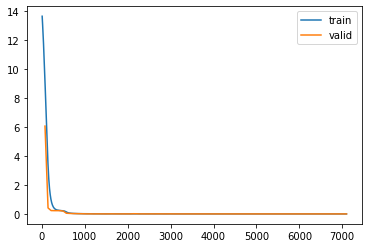

In [15]:
recorder.plot_loss()

Finally, we check the MSE. It is quite low. Perhaps too low?

In [16]:
learn.validate()

(#1) [6.4823652792256325e-06]

# **Step 5: Plotting the Outputs of the Network**

Saving files.

In [17]:
# Validating
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

We define a custom_unnormalize function in order to return to physical quantities.

In [18]:
# Defining a custom_unnormalize function
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

Finally, we plot histograms of the outputs of the network versus the inputs.

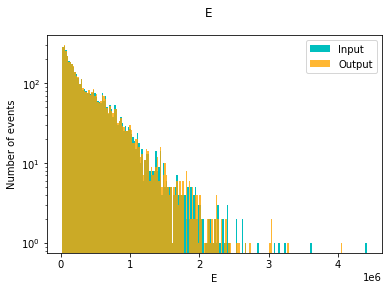

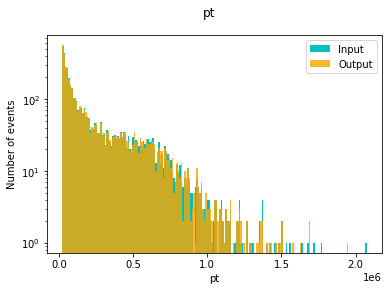

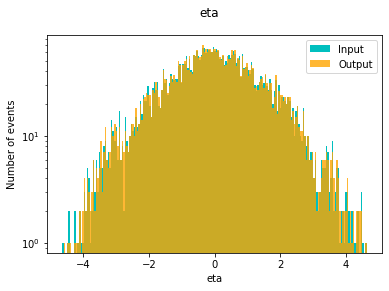

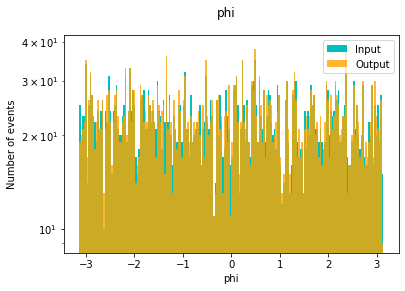

In [19]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[GeV]', '[rad]', '[rad]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 20000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()